# Some preprocessing to implement tanh in generator

In [1]:
import pandas as pd
# normalized_df=(df-df.mean())/df.std()
df = pd.read_csv('train.csv')
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]
df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
df.Sex = df.Sex.replace({'male':0,'female':1})
df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})

# Importing the dependencies

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns

# Creating pytorch dataset and dataloader

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
class MyDataset(Dataset):
 
  def __init__(self):
    df = pd.read_csv('train.csv')
    df["label"] = df.Survived
#     df = df[df['label'] == 1].reset_index(drop = True)
    df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
    median_age = df.Age.median()
    mode_embarked = df.Embarked.mode()[0]
    df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
    df.Sex = df.Sex.replace({'male':0,'female':1})
    df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})
 
    x = df.iloc[:, 0:7].values
    y = df.iloc[:, -1].values
 
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset()

In [5]:
batch_size = 64


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [7]:
train_dl = DeviceDataLoader(train_dl, device)

In [8]:
train_dl.device

device(type='cuda')

# Creating generator and discriminator models

<b> Generator Architecture

In [9]:
latent_size = 7
n_features = 7
num_classes = 2
embed_size = 2

In [10]:
class Generator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
#             nn.Linear(latent_size, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 7),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels)#.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    

generator = to_device(Generator(), device)

<b> Discriminator Architecture

In [11]:
class Discriminator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
#             nn.Linear(n_features, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 1),
#             nn.Sigmoid()
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels)#.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    
discriminator = to_device(Discriminator(), device)

In [12]:
# for arr, labels in train_dl:
#     break
# # nn.Embedding(2, 2).to('cuda')(labels)#.reshape(labels.shape[0], 1)

# Generator and discriminator training methodology

In [13]:
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [14]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(real_data, opt_d, cur_batch_size, real_labels):
    # Reset gradients
    opt_d.zero_grad()
    
    real_labels = real_labels.to(device)
    real_preds = discriminator(real_data, real_labels).reshape(-1)

    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels).reshape(-1)
    
    loss = -(torch.mean(real_preds) - torch.mean(fake_preds))#d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
    # clip critic weights between -0.01, 0.01
    for p in discriminator.parameters():
        p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        
    return loss

In [15]:
def train_generator(opt_g, cur_batch_size, real_labels):
    # Clear generator gradients
    opt_g.zero_grad()
     
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels.to(device)).reshape(-1)
    g_loss = -torch.mean(fake_preds)

    g_loss.backward()
    opt_g.step()
    return g_loss

# Training Loop

In [16]:
lr = 0.001
epochs = 1000

In [17]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
opt_g = torch.optim.Adam(generator.parameters(), lr=lr)

In [18]:
def fit(epochs, lr, opt_d, opt_g):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []

    
    # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    total_step = len(train_dl)
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(train_dl):
            cur_batch_size = real_data.shape[0]
            
            for _ in range(CRITIC_ITERATIONS):            
                # Train the discriminator and generator
                d_loss = train_discriminator(real_data, opt_d, cur_batch_size, real_labels)            
                
            g_loss = train_generator(opt_g, cur_batch_size, real_labels)
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item()))
        # Loss of last batch
        losses_d.append(d_loss.item())
        losses_g.append(g_loss.item())
    return losses_g, losses_d

In [19]:
%%time

history = fit(epochs, lr, opt_d, opt_g)

Epoch [0/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4975
Epoch [0/1000], Step [2/14], d_loss: -0.0009, g_loss: -0.4975
Epoch [0/1000], Step [3/14], d_loss: -0.0018, g_loss: -0.4975
Epoch [0/1000], Step [4/14], d_loss: -0.0037, g_loss: -0.4976
Epoch [0/1000], Step [5/14], d_loss: -0.0065, g_loss: -0.4976
Epoch [0/1000], Step [6/14], d_loss: -0.0124, g_loss: -0.4976
Epoch [0/1000], Step [7/14], d_loss: -0.0165, g_loss: -0.4975
Epoch [0/1000], Step [8/14], d_loss: -0.0273, g_loss: -0.4975
Epoch [0/1000], Step [9/14], d_loss: -0.0320, g_loss: -0.4975
Epoch [0/1000], Step [10/14], d_loss: -0.0350, g_loss: -0.4975
Epoch [0/1000], Step [11/14], d_loss: -0.0473, g_loss: -0.4974
Epoch [0/1000], Step [12/14], d_loss: -0.0404, g_loss: -0.4974
Epoch [0/1000], Step [13/14], d_loss: -0.0484, g_loss: -0.4974
Epoch [0/1000], Step [14/14], d_loss: -0.0544, g_loss: -0.4974
Epoch [1/1000], Step [1/14], d_loss: -0.0499, g_loss: -0.4974
Epoch [1/1000], Step [2/14], d_loss: -0.0520, g_loss: -0.4974
Epo

Epoch [9/1000], Step [8/14], d_loss: -0.0598, g_loss: -0.5124
Epoch [9/1000], Step [9/14], d_loss: -0.0347, g_loss: -0.5145
Epoch [9/1000], Step [10/14], d_loss: -0.0421, g_loss: -0.5165
Epoch [9/1000], Step [11/14], d_loss: -0.0496, g_loss: -0.5186
Epoch [9/1000], Step [12/14], d_loss: -0.0460, g_loss: -0.5182
Epoch [9/1000], Step [13/14], d_loss: -0.0333, g_loss: -0.5169
Epoch [9/1000], Step [14/14], d_loss: -0.0313, g_loss: -0.5215
Epoch [10/1000], Step [1/14], d_loss: -0.0415, g_loss: -0.5228
Epoch [10/1000], Step [2/14], d_loss: -0.0314, g_loss: -0.5224
Epoch [10/1000], Step [3/14], d_loss: -0.0363, g_loss: -0.5218
Epoch [10/1000], Step [4/14], d_loss: -0.0365, g_loss: -0.5223
Epoch [10/1000], Step [5/14], d_loss: -0.0331, g_loss: -0.5210
Epoch [10/1000], Step [6/14], d_loss: -0.0344, g_loss: -0.5246
Epoch [10/1000], Step [7/14], d_loss: -0.0308, g_loss: -0.5239
Epoch [10/1000], Step [8/14], d_loss: -0.0311, g_loss: -0.5256
Epoch [10/1000], Step [9/14], d_loss: -0.0308, g_loss: -0

Epoch [18/1000], Step [12/14], d_loss: -0.0170, g_loss: -0.4918
Epoch [18/1000], Step [13/14], d_loss: -0.0170, g_loss: -0.4918
Epoch [18/1000], Step [14/14], d_loss: -0.0161, g_loss: -0.4915
Epoch [19/1000], Step [1/14], d_loss: -0.0150, g_loss: -0.4918
Epoch [19/1000], Step [2/14], d_loss: -0.0157, g_loss: -0.4910
Epoch [19/1000], Step [3/14], d_loss: -0.0169, g_loss: -0.4920
Epoch [19/1000], Step [4/14], d_loss: -0.0157, g_loss: -0.4915
Epoch [19/1000], Step [5/14], d_loss: -0.0185, g_loss: -0.4917
Epoch [19/1000], Step [6/14], d_loss: -0.0155, g_loss: -0.4916
Epoch [19/1000], Step [7/14], d_loss: -0.0163, g_loss: -0.4913
Epoch [19/1000], Step [8/14], d_loss: -0.0169, g_loss: -0.4911
Epoch [19/1000], Step [9/14], d_loss: -0.0136, g_loss: -0.4910
Epoch [19/1000], Step [10/14], d_loss: -0.0169, g_loss: -0.4920
Epoch [19/1000], Step [11/14], d_loss: -0.0172, g_loss: -0.4911
Epoch [19/1000], Step [12/14], d_loss: -0.0130, g_loss: -0.4911
Epoch [19/1000], Step [13/14], d_loss: -0.0149, g

Epoch [28/1000], Step [8/14], d_loss: -0.0076, g_loss: -0.4935
Epoch [28/1000], Step [9/14], d_loss: -0.0080, g_loss: -0.4927
Epoch [28/1000], Step [10/14], d_loss: -0.0069, g_loss: -0.4923
Epoch [28/1000], Step [11/14], d_loss: -0.0085, g_loss: -0.4925
Epoch [28/1000], Step [12/14], d_loss: -0.0064, g_loss: -0.4928
Epoch [28/1000], Step [13/14], d_loss: -0.0080, g_loss: -0.4927
Epoch [28/1000], Step [14/14], d_loss: -0.0088, g_loss: -0.4931
Epoch [29/1000], Step [1/14], d_loss: -0.0097, g_loss: -0.4932
Epoch [29/1000], Step [2/14], d_loss: -0.0069, g_loss: -0.4931
Epoch [29/1000], Step [3/14], d_loss: -0.0076, g_loss: -0.4925
Epoch [29/1000], Step [4/14], d_loss: -0.0077, g_loss: -0.4924
Epoch [29/1000], Step [5/14], d_loss: -0.0094, g_loss: -0.4924
Epoch [29/1000], Step [6/14], d_loss: -0.0074, g_loss: -0.4927
Epoch [29/1000], Step [7/14], d_loss: -0.0074, g_loss: -0.4923
Epoch [29/1000], Step [8/14], d_loss: -0.0079, g_loss: -0.4930
Epoch [29/1000], Step [9/14], d_loss: -0.0079, g_l

Epoch [38/1000], Step [2/14], d_loss: -0.0081, g_loss: -0.4948
Epoch [38/1000], Step [3/14], d_loss: -0.0055, g_loss: -0.4953
Epoch [38/1000], Step [4/14], d_loss: -0.0079, g_loss: -0.4953
Epoch [38/1000], Step [5/14], d_loss: -0.0084, g_loss: -0.4946
Epoch [38/1000], Step [6/14], d_loss: -0.0055, g_loss: -0.4947
Epoch [38/1000], Step [7/14], d_loss: -0.0063, g_loss: -0.4952
Epoch [38/1000], Step [8/14], d_loss: -0.0061, g_loss: -0.4954
Epoch [38/1000], Step [9/14], d_loss: -0.0061, g_loss: -0.4948
Epoch [38/1000], Step [10/14], d_loss: -0.0070, g_loss: -0.4950
Epoch [38/1000], Step [11/14], d_loss: -0.0083, g_loss: -0.4947
Epoch [38/1000], Step [12/14], d_loss: -0.0065, g_loss: -0.4948
Epoch [38/1000], Step [13/14], d_loss: -0.0081, g_loss: -0.4948
Epoch [38/1000], Step [14/14], d_loss: -0.0061, g_loss: -0.4955
Epoch [39/1000], Step [1/14], d_loss: -0.0063, g_loss: -0.4956
Epoch [39/1000], Step [2/14], d_loss: -0.0078, g_loss: -0.4950
Epoch [39/1000], Step [3/14], d_loss: -0.0060, g_l

Epoch [47/1000], Step [10/14], d_loss: -0.0078, g_loss: -0.4959
Epoch [47/1000], Step [11/14], d_loss: -0.0076, g_loss: -0.4951
Epoch [47/1000], Step [12/14], d_loss: -0.0071, g_loss: -0.4953
Epoch [47/1000], Step [13/14], d_loss: -0.0058, g_loss: -0.4956
Epoch [47/1000], Step [14/14], d_loss: -0.0079, g_loss: -0.4951
Epoch [48/1000], Step [1/14], d_loss: -0.0053, g_loss: -0.4953
Epoch [48/1000], Step [2/14], d_loss: -0.0070, g_loss: -0.4962
Epoch [48/1000], Step [3/14], d_loss: -0.0043, g_loss: -0.4968
Epoch [48/1000], Step [4/14], d_loss: -0.0071, g_loss: -0.4966
Epoch [48/1000], Step [5/14], d_loss: -0.0087, g_loss: -0.4950
Epoch [48/1000], Step [6/14], d_loss: -0.0068, g_loss: -0.4949
Epoch [48/1000], Step [7/14], d_loss: -0.0079, g_loss: -0.4973
Epoch [48/1000], Step [8/14], d_loss: -0.0087, g_loss: -0.4972
Epoch [48/1000], Step [9/14], d_loss: -0.0105, g_loss: -0.4951
Epoch [48/1000], Step [10/14], d_loss: -0.0088, g_loss: -0.4951
Epoch [48/1000], Step [11/14], d_loss: -0.0088, g

Epoch [57/1000], Step [1/14], d_loss: -0.0137, g_loss: -0.4969
Epoch [57/1000], Step [2/14], d_loss: -0.0163, g_loss: -0.4961
Epoch [57/1000], Step [3/14], d_loss: -0.0159, g_loss: -0.4962
Epoch [57/1000], Step [4/14], d_loss: -0.0199, g_loss: -0.4964
Epoch [57/1000], Step [5/14], d_loss: -0.0188, g_loss: -0.4974
Epoch [57/1000], Step [6/14], d_loss: -0.0196, g_loss: -0.4965
Epoch [57/1000], Step [7/14], d_loss: -0.0150, g_loss: -0.4961
Epoch [57/1000], Step [8/14], d_loss: -0.0135, g_loss: -0.4970
Epoch [57/1000], Step [9/14], d_loss: -0.0145, g_loss: -0.4968
Epoch [57/1000], Step [10/14], d_loss: -0.0115, g_loss: -0.4979
Epoch [57/1000], Step [11/14], d_loss: -0.0162, g_loss: -0.4962
Epoch [57/1000], Step [12/14], d_loss: -0.0165, g_loss: -0.4972
Epoch [57/1000], Step [13/14], d_loss: -0.0154, g_loss: -0.4979
Epoch [57/1000], Step [14/14], d_loss: -0.0137, g_loss: -0.4974
Epoch [58/1000], Step [1/14], d_loss: -0.0085, g_loss: -0.4988
Epoch [58/1000], Step [2/14], d_loss: -0.0130, g_l

Epoch [66/1000], Step [9/14], d_loss: -0.0186, g_loss: -0.4967
Epoch [66/1000], Step [10/14], d_loss: -0.0112, g_loss: -0.4957
Epoch [66/1000], Step [11/14], d_loss: -0.0121, g_loss: -0.4964
Epoch [66/1000], Step [12/14], d_loss: -0.0138, g_loss: -0.4958
Epoch [66/1000], Step [13/14], d_loss: -0.0133, g_loss: -0.4957
Epoch [66/1000], Step [14/14], d_loss: -0.0094, g_loss: -0.5001
Epoch [67/1000], Step [1/14], d_loss: -0.0135, g_loss: -0.4947
Epoch [67/1000], Step [2/14], d_loss: -0.0161, g_loss: -0.4966
Epoch [67/1000], Step [3/14], d_loss: -0.0130, g_loss: -0.4968
Epoch [67/1000], Step [4/14], d_loss: -0.0176, g_loss: -0.4956
Epoch [67/1000], Step [5/14], d_loss: -0.0135, g_loss: -0.4948
Epoch [67/1000], Step [6/14], d_loss: -0.0150, g_loss: -0.4965
Epoch [67/1000], Step [7/14], d_loss: -0.0148, g_loss: -0.4948
Epoch [67/1000], Step [8/14], d_loss: -0.0142, g_loss: -0.4977
Epoch [67/1000], Step [9/14], d_loss: -0.0170, g_loss: -0.4949
Epoch [67/1000], Step [10/14], d_loss: -0.0143, g_

Epoch [76/1000], Step [2/14], d_loss: -0.0123, g_loss: -0.4992
Epoch [76/1000], Step [3/14], d_loss: -0.0143, g_loss: -0.4954
Epoch [76/1000], Step [4/14], d_loss: -0.0171, g_loss: -0.4964
Epoch [76/1000], Step [5/14], d_loss: -0.0181, g_loss: -0.4958
Epoch [76/1000], Step [6/14], d_loss: -0.0160, g_loss: -0.4967
Epoch [76/1000], Step [7/14], d_loss: -0.0159, g_loss: -0.4973
Epoch [76/1000], Step [8/14], d_loss: -0.0142, g_loss: -0.4969
Epoch [76/1000], Step [9/14], d_loss: -0.0119, g_loss: -0.4974
Epoch [76/1000], Step [10/14], d_loss: -0.0125, g_loss: -0.4963
Epoch [76/1000], Step [11/14], d_loss: -0.0129, g_loss: -0.4997
Epoch [76/1000], Step [12/14], d_loss: -0.0115, g_loss: -0.4963
Epoch [76/1000], Step [13/14], d_loss: -0.0112, g_loss: -0.4971
Epoch [76/1000], Step [14/14], d_loss: -0.0125, g_loss: -0.4976
Epoch [77/1000], Step [1/14], d_loss: -0.0086, g_loss: -0.4960
Epoch [77/1000], Step [2/14], d_loss: -0.0150, g_loss: -0.4984
Epoch [77/1000], Step [3/14], d_loss: -0.0098, g_l

Epoch [85/1000], Step [7/14], d_loss: -0.0150, g_loss: -0.4967
Epoch [85/1000], Step [8/14], d_loss: -0.0165, g_loss: -0.4951
Epoch [85/1000], Step [9/14], d_loss: -0.0147, g_loss: -0.4938
Epoch [85/1000], Step [10/14], d_loss: -0.0132, g_loss: -0.4974
Epoch [85/1000], Step [11/14], d_loss: -0.0119, g_loss: -0.4958
Epoch [85/1000], Step [12/14], d_loss: -0.0149, g_loss: -0.4954
Epoch [85/1000], Step [13/14], d_loss: -0.0109, g_loss: -0.4965
Epoch [85/1000], Step [14/14], d_loss: -0.0103, g_loss: -0.4960
Epoch [86/1000], Step [1/14], d_loss: -0.0096, g_loss: -0.4970
Epoch [86/1000], Step [2/14], d_loss: -0.0109, g_loss: -0.4941
Epoch [86/1000], Step [3/14], d_loss: -0.0145, g_loss: -0.4964
Epoch [86/1000], Step [4/14], d_loss: -0.0104, g_loss: -0.4979
Epoch [86/1000], Step [5/14], d_loss: -0.0141, g_loss: -0.4943
Epoch [86/1000], Step [6/14], d_loss: -0.0122, g_loss: -0.4939
Epoch [86/1000], Step [7/14], d_loss: -0.0131, g_loss: -0.4942
Epoch [86/1000], Step [8/14], d_loss: -0.0111, g_l

Epoch [94/1000], Step [13/14], d_loss: -0.0123, g_loss: -0.5003
Epoch [94/1000], Step [14/14], d_loss: -0.0128, g_loss: -0.4975
Epoch [95/1000], Step [1/14], d_loss: -0.0109, g_loss: -0.4967
Epoch [95/1000], Step [2/14], d_loss: -0.0134, g_loss: -0.4994
Epoch [95/1000], Step [3/14], d_loss: -0.0135, g_loss: -0.4944
Epoch [95/1000], Step [4/14], d_loss: -0.0143, g_loss: -0.5008
Epoch [95/1000], Step [5/14], d_loss: -0.0138, g_loss: -0.4952
Epoch [95/1000], Step [6/14], d_loss: -0.0106, g_loss: -0.4973
Epoch [95/1000], Step [7/14], d_loss: -0.0094, g_loss: -0.4990
Epoch [95/1000], Step [8/14], d_loss: -0.0104, g_loss: -0.4931
Epoch [95/1000], Step [9/14], d_loss: -0.0107, g_loss: -0.5002
Epoch [95/1000], Step [10/14], d_loss: -0.0116, g_loss: -0.4956
Epoch [95/1000], Step [11/14], d_loss: -0.0141, g_loss: -0.4972
Epoch [95/1000], Step [12/14], d_loss: -0.0081, g_loss: -0.4967
Epoch [95/1000], Step [13/14], d_loss: -0.0084, g_loss: -0.4950
Epoch [95/1000], Step [14/14], d_loss: -0.0121, g

Epoch [104/1000], Step [4/14], d_loss: -0.0094, g_loss: -0.5013
Epoch [104/1000], Step [5/14], d_loss: -0.0121, g_loss: -0.4995
Epoch [104/1000], Step [6/14], d_loss: -0.0130, g_loss: -0.5046
Epoch [104/1000], Step [7/14], d_loss: -0.0077, g_loss: -0.5067
Epoch [104/1000], Step [8/14], d_loss: -0.0172, g_loss: -0.5095
Epoch [104/1000], Step [9/14], d_loss: -0.0095, g_loss: -0.5041
Epoch [104/1000], Step [10/14], d_loss: -0.0084, g_loss: -0.5080
Epoch [104/1000], Step [11/14], d_loss: -0.0091, g_loss: -0.5086
Epoch [104/1000], Step [12/14], d_loss: -0.0064, g_loss: -0.5071
Epoch [104/1000], Step [13/14], d_loss: -0.0060, g_loss: -0.5066
Epoch [104/1000], Step [14/14], d_loss: -0.0079, g_loss: -0.5093
Epoch [105/1000], Step [1/14], d_loss: -0.0068, g_loss: -0.5106
Epoch [105/1000], Step [2/14], d_loss: -0.0067, g_loss: -0.5083
Epoch [105/1000], Step [3/14], d_loss: -0.0047, g_loss: -0.5036
Epoch [105/1000], Step [4/14], d_loss: -0.0080, g_loss: -0.5086
Epoch [105/1000], Step [5/14], d_lo

Epoch [113/1000], Step [11/14], d_loss: -0.0116, g_loss: -0.5217
Epoch [113/1000], Step [12/14], d_loss: -0.0036, g_loss: -0.5245
Epoch [113/1000], Step [13/14], d_loss: -0.0049, g_loss: -0.5237
Epoch [113/1000], Step [14/14], d_loss: -0.0015, g_loss: -0.5224
Epoch [114/1000], Step [1/14], d_loss: -0.0019, g_loss: -0.5275
Epoch [114/1000], Step [2/14], d_loss: -0.0059, g_loss: -0.5276
Epoch [114/1000], Step [3/14], d_loss: -0.0024, g_loss: -0.5270
Epoch [114/1000], Step [4/14], d_loss: 0.0024, g_loss: -0.5294
Epoch [114/1000], Step [5/14], d_loss: -0.0082, g_loss: -0.5263
Epoch [114/1000], Step [6/14], d_loss: 0.0002, g_loss: -0.5247
Epoch [114/1000], Step [7/14], d_loss: 0.0009, g_loss: -0.5213
Epoch [114/1000], Step [8/14], d_loss: -0.0039, g_loss: -0.5195
Epoch [114/1000], Step [9/14], d_loss: -0.0010, g_loss: -0.5121
Epoch [114/1000], Step [10/14], d_loss: 0.0005, g_loss: -0.5049
Epoch [114/1000], Step [11/14], d_loss: -0.0012, g_loss: -0.4927
Epoch [114/1000], Step [12/14], d_loss

Epoch [122/1000], Step [13/14], d_loss: -0.0008, g_loss: -0.4971
Epoch [122/1000], Step [14/14], d_loss: -0.0032, g_loss: -0.4979
Epoch [123/1000], Step [1/14], d_loss: -0.0008, g_loss: -0.4986
Epoch [123/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4952
Epoch [123/1000], Step [3/14], d_loss: -0.0004, g_loss: -0.4936
Epoch [123/1000], Step [4/14], d_loss: -0.0017, g_loss: -0.4963
Epoch [123/1000], Step [5/14], d_loss: -0.0009, g_loss: -0.4945
Epoch [123/1000], Step [6/14], d_loss: -0.0012, g_loss: -0.4969
Epoch [123/1000], Step [7/14], d_loss: -0.0008, g_loss: -0.5008
Epoch [123/1000], Step [8/14], d_loss: -0.0013, g_loss: -0.5009
Epoch [123/1000], Step [9/14], d_loss: -0.0004, g_loss: -0.5029
Epoch [123/1000], Step [10/14], d_loss: 0.0001, g_loss: -0.5046
Epoch [123/1000], Step [11/14], d_loss: -0.0008, g_loss: -0.5024
Epoch [123/1000], Step [12/14], d_loss: -0.0018, g_loss: -0.4969
Epoch [123/1000], Step [13/14], d_loss: -0.0020, g_loss: -0.4968
Epoch [123/1000], Step [14/14], d_l

Epoch [132/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4978
Epoch [132/1000], Step [6/14], d_loss: -0.0006, g_loss: -0.4973
Epoch [132/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4969
Epoch [132/1000], Step [8/14], d_loss: -0.0005, g_loss: -0.4975
Epoch [132/1000], Step [9/14], d_loss: -0.0007, g_loss: -0.4990
Epoch [132/1000], Step [10/14], d_loss: -0.0008, g_loss: -0.4974
Epoch [132/1000], Step [11/14], d_loss: -0.0008, g_loss: -0.4970
Epoch [132/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4974
Epoch [132/1000], Step [13/14], d_loss: -0.0004, g_loss: -0.4973
Epoch [132/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4964
Epoch [133/1000], Step [1/14], d_loss: -0.0007, g_loss: -0.4963
Epoch [133/1000], Step [2/14], d_loss: -0.0006, g_loss: -0.4969
Epoch [133/1000], Step [3/14], d_loss: 0.0003, g_loss: -0.4979
Epoch [133/1000], Step [4/14], d_loss: -0.0006, g_loss: -0.4958
Epoch [133/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4956
Epoch [133/1000], Step [6/14], d_los

Epoch [141/1000], Step [7/14], d_loss: -0.0004, g_loss: -0.4985
Epoch [141/1000], Step [8/14], d_loss: -0.0004, g_loss: -0.4988
Epoch [141/1000], Step [9/14], d_loss: -0.0005, g_loss: -0.4992
Epoch [141/1000], Step [10/14], d_loss: -0.0004, g_loss: -0.4985
Epoch [141/1000], Step [11/14], d_loss: -0.0004, g_loss: -0.4985
Epoch [141/1000], Step [12/14], d_loss: -0.0006, g_loss: -0.4987
Epoch [141/1000], Step [13/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [141/1000], Step [14/14], d_loss: -0.0006, g_loss: -0.4990
Epoch [142/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4986
Epoch [142/1000], Step [2/14], d_loss: -0.0005, g_loss: -0.4987
Epoch [142/1000], Step [3/14], d_loss: -0.0005, g_loss: -0.4986
Epoch [142/1000], Step [4/14], d_loss: -0.0004, g_loss: -0.4983
Epoch [142/1000], Step [5/14], d_loss: -0.0006, g_loss: -0.4987
Epoch [142/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4990
Epoch [142/1000], Step [7/14], d_loss: -0.0007, g_loss: -0.4988
Epoch [142/1000], Step [8/14], d_lo

Epoch [150/1000], Step [13/14], d_loss: -0.0004, g_loss: -0.4993
Epoch [150/1000], Step [14/14], d_loss: -0.0004, g_loss: -0.4994
Epoch [151/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [151/1000], Step [2/14], d_loss: -0.0004, g_loss: -0.4994
Epoch [151/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [151/1000], Step [4/14], d_loss: -0.0007, g_loss: -0.4995
Epoch [151/1000], Step [5/14], d_loss: -0.0006, g_loss: -0.4997
Epoch [151/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [151/1000], Step [7/14], d_loss: -0.0007, g_loss: -0.4996
Epoch [151/1000], Step [8/14], d_loss: -0.0005, g_loss: -0.4998
Epoch [151/1000], Step [9/14], d_loss: -0.0005, g_loss: -0.4997
Epoch [151/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [151/1000], Step [11/14], d_loss: -0.0005, g_loss: -0.4995
Epoch [151/1000], Step [12/14], d_loss: -0.0004, g_loss: -0.4994
Epoch [151/1000], Step [13/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [151/1000], Step [14/14], d_

Epoch [160/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [160/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [160/1000], Step [8/14], d_loss: -0.0005, g_loss: -0.5000
Epoch [160/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4998
Epoch [160/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [160/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [160/1000], Step [12/14], d_loss: -0.0005, g_loss: -0.4995
Epoch [160/1000], Step [13/14], d_loss: -0.0004, g_loss: -0.4997
Epoch [160/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [161/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [161/1000], Step [2/14], d_loss: -0.0005, g_loss: -0.4997
Epoch [161/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [161/1000], Step [4/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [161/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [161/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [161/1000], Step [7/14], d_lo

Epoch [169/1000], Step [10/14], d_loss: -0.0005, g_loss: -0.5013
Epoch [169/1000], Step [11/14], d_loss: -0.0016, g_loss: -0.5014
Epoch [169/1000], Step [12/14], d_loss: -0.0011, g_loss: -0.5013
Epoch [169/1000], Step [13/14], d_loss: -0.0026, g_loss: -0.5023
Epoch [169/1000], Step [14/14], d_loss: 0.0003, g_loss: -0.5007
Epoch [170/1000], Step [1/14], d_loss: 0.0020, g_loss: -0.5008
Epoch [170/1000], Step [2/14], d_loss: 0.0000, g_loss: -0.5006
Epoch [170/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.5004
Epoch [170/1000], Step [4/14], d_loss: -0.0007, g_loss: -0.4998
Epoch [170/1000], Step [5/14], d_loss: -0.0005, g_loss: -0.5005
Epoch [170/1000], Step [6/14], d_loss: -0.0015, g_loss: -0.5015
Epoch [170/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.5008
Epoch [170/1000], Step [8/14], d_loss: -0.0024, g_loss: -0.5009
Epoch [170/1000], Step [9/14], d_loss: -0.0007, g_loss: -0.5005
Epoch [170/1000], Step [10/14], d_loss: -0.0042, g_loss: -0.5010
Epoch [170/1000], Step [11/14], d_los

Epoch [179/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [179/1000], Step [3/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [179/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4991
Epoch [179/1000], Step [5/14], d_loss: -0.0005, g_loss: -0.4991
Epoch [179/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4990
Epoch [179/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4989
Epoch [179/1000], Step [8/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [179/1000], Step [9/14], d_loss: -0.0002, g_loss: -0.4989
Epoch [179/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [179/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [179/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [179/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [179/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [180/1000], Step [1/14], d_loss: -0.0006, g_loss: -0.4995
Epoch [180/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [180/1000], Step [3/14], d_lo

Epoch [188/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [188/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [188/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [188/1000], Step [8/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [188/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [188/1000], Step [10/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [188/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4998
Epoch [188/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4997
Epoch [188/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [188/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [189/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [189/1000], Step [2/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [189/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [189/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [189/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [189/1000], Step [6/14], d_lo

Epoch [197/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [197/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [197/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [197/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [197/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4998
Epoch [197/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4998
Epoch [197/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [197/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [198/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [198/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4998
Epoch [198/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [198/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4999
Epoch [198/1000], Step [5/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [198/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [198/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [198/1000], Step [8/14], d_lo

Epoch [206/1000], Step [12/14], d_loss: -0.0011, g_loss: -0.5003
Epoch [206/1000], Step [13/14], d_loss: 0.0001, g_loss: -0.4992
Epoch [206/1000], Step [14/14], d_loss: -0.0011, g_loss: -0.4999
Epoch [207/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [207/1000], Step [2/14], d_loss: -0.0005, g_loss: -0.5001
Epoch [207/1000], Step [3/14], d_loss: -0.0009, g_loss: -0.5004
Epoch [207/1000], Step [4/14], d_loss: -0.0018, g_loss: -0.5004
Epoch [207/1000], Step [5/14], d_loss: -0.0010, g_loss: -0.5003
Epoch [207/1000], Step [6/14], d_loss: -0.0007, g_loss: -0.5000
Epoch [207/1000], Step [7/14], d_loss: -0.0008, g_loss: -0.5004
Epoch [207/1000], Step [8/14], d_loss: -0.0003, g_loss: -0.5003
Epoch [207/1000], Step [9/14], d_loss: -0.0005, g_loss: -0.5003
Epoch [207/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.5002
Epoch [207/1000], Step [11/14], d_loss: -0.0004, g_loss: -0.4995
Epoch [207/1000], Step [12/14], d_loss: -0.0010, g_loss: -0.4994
Epoch [207/1000], Step [13/14], d_l

Epoch [216/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4977
Epoch [216/1000], Step [6/14], d_loss: 0.0001, g_loss: -0.4977
Epoch [216/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4976
Epoch [216/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4976
Epoch [216/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4977
Epoch [216/1000], Step [10/14], d_loss: -0.0008, g_loss: -0.4980
Epoch [216/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4981
Epoch [216/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4979
Epoch [216/1000], Step [13/14], d_loss: 0.0000, g_loss: -0.4975
Epoch [216/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4972
Epoch [217/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4972
Epoch [217/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4971
Epoch [217/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4972
Epoch [217/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4972
Epoch [217/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4974
Epoch [217/1000], Step [6/14], d_loss

Epoch [225/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [225/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [225/1000], Step [13/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [225/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [226/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4998
Epoch [226/1000], Step [2/14], d_loss: -0.0003, g_loss: -0.4998
Epoch [226/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [226/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [226/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [226/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [226/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [226/1000], Step [8/14], d_loss: -0.0004, g_loss: -0.4999
Epoch [226/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4998
Epoch [226/1000], Step [10/14], d_loss: -0.0003, g_loss: -0.4999
Epoch [226/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4998
Epoch [226/1000], Step [12/14], d_

Epoch [235/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [235/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [235/1000], Step [3/14], d_loss: -0.0005, g_loss: -0.4996
Epoch [235/1000], Step [4/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [235/1000], Step [5/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [235/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [235/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [235/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [235/1000], Step [9/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [235/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [235/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [235/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [235/1000], Step [13/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [235/1000], Step [14/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [236/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [236/1000], Step [2/14], d_lo

Epoch [244/1000], Step [8/14], d_loss: -0.0003, g_loss: -0.4992
Epoch [244/1000], Step [9/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [244/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [244/1000], Step [11/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [244/1000], Step [12/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [244/1000], Step [13/14], d_loss: -0.0003, g_loss: -0.4991
Epoch [244/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [245/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [245/1000], Step [2/14], d_loss: -0.0003, g_loss: -0.4992
Epoch [245/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [245/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [245/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4991
Epoch [245/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4991
Epoch [245/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4992
Epoch [245/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [245/1000], Step [9/14], d_lo

Epoch [254/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [254/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [254/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [254/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [254/1000], Step [6/14], d_loss: -0.0004, g_loss: -0.4992
Epoch [254/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [254/1000], Step [8/14], d_loss: -0.0004, g_loss: -0.4995
Epoch [254/1000], Step [9/14], d_loss: -0.0004, g_loss: -0.4995
Epoch [254/1000], Step [10/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [254/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [254/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [254/1000], Step [13/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [254/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [255/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4994
Epoch [255/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [255/1000], Step [3/14], d_lo

Epoch [263/1000], Step [9/14], d_loss: 0.0000, g_loss: -0.4991
Epoch [263/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [263/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [263/1000], Step [12/14], d_loss: -0.0003, g_loss: -0.4991
Epoch [263/1000], Step [13/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [263/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [264/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [264/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [264/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [264/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [264/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [264/1000], Step [6/14], d_loss: -0.0004, g_loss: -0.4996
Epoch [264/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [264/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [264/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [264/1000], Step [10/14], d_lo

Epoch [272/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4982
Epoch [273/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4984
Epoch [273/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4985
Epoch [273/1000], Step [3/14], d_loss: -0.0003, g_loss: -0.4986
Epoch [273/1000], Step [4/14], d_loss: -0.0003, g_loss: -0.4986
Epoch [273/1000], Step [5/14], d_loss: -0.0005, g_loss: -0.4988
Epoch [273/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4987
Epoch [273/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4987
Epoch [273/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4986
Epoch [273/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4987
Epoch [273/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4989
Epoch [273/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [273/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [273/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [273/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [274/1000], Step [1/14], d_l

Epoch [282/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [282/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [282/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [282/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [282/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [282/1000], Step [12/14], d_loss: -0.0004, g_loss: -0.4994
Epoch [282/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [282/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4994
Epoch [283/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [283/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [283/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [283/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [283/1000], Step [5/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [283/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [283/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [283/1000], Step [8/14], d_lo

Epoch [291/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [292/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [292/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [292/1000], Step [3/14], d_loss: 0.0000, g_loss: -0.4995
Epoch [292/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [292/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [292/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [292/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [292/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [292/1000], Step [9/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [292/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [292/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [292/1000], Step [12/14], d_loss: -0.0003, g_loss: -0.4997
Epoch [292/1000], Step [13/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [292/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4995
Epoch [293/1000], Step [1/14], d_lo

Epoch [301/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [301/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [301/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4991
Epoch [301/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4988
Epoch [301/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4987
Epoch [301/1000], Step [10/14], d_loss: -0.0003, g_loss: -0.4985
Epoch [301/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4984
Epoch [301/1000], Step [12/14], d_loss: -0.0003, g_loss: -0.4984
Epoch [301/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4983
Epoch [301/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4983
Epoch [302/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4986
Epoch [302/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4988
Epoch [302/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4990
Epoch [302/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [302/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [302/1000], Step [6/14], d_lo

Epoch [310/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [310/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [310/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [310/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [310/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4992
Epoch [310/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4990
Epoch [310/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4991
Epoch [310/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [311/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4993
Epoch [311/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [311/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [311/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [311/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [311/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [311/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4988
Epoch [311/1000], Step [8/14], d_lo

Epoch [319/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [320/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [320/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [320/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [320/1000], Step [4/14], d_loss: 0.0000, g_loss: -0.4998
Epoch [320/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4999
Epoch [320/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [320/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.5001
Epoch [320/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.5001
Epoch [320/1000], Step [9/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [320/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [320/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [320/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4993
Epoch [320/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4992
Epoch [320/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [321/1000], Step [1/14], d_lo

Epoch [329/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4992
Epoch [329/1000], Step [7/14], d_loss: -0.0004, g_loss: -0.4987
Epoch [329/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4984
Epoch [329/1000], Step [9/14], d_loss: -0.0004, g_loss: -0.4984
Epoch [329/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4983
Epoch [329/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4986
Epoch [329/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.4988
Epoch [329/1000], Step [13/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [329/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [330/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [330/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [330/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [330/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4986
Epoch [330/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4984
Epoch [330/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4984
Epoch [330/1000], Step [7/14], d_lo

Epoch [338/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4985
Epoch [338/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4985
Epoch [338/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4988
Epoch [339/1000], Step [1/14], d_loss: 0.0000, g_loss: -0.4992
Epoch [339/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [339/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4994
Epoch [339/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.4990
Epoch [339/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4985
Epoch [339/1000], Step [6/14], d_loss: 0.0000, g_loss: -0.4985
Epoch [339/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4986
Epoch [339/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4988
Epoch [339/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4989
Epoch [339/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [339/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4992
Epoch [339/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [339/1000], Step [13/14], d_lo

Epoch [347/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.4986
Epoch [348/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4985
Epoch [348/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4985
Epoch [348/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4986
Epoch [348/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [348/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [348/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [348/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [348/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4994
Epoch [348/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4991
Epoch [348/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [348/1000], Step [11/14], d_loss: -0.0003, g_loss: -0.4991
Epoch [348/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.4988
Epoch [348/1000], Step [13/14], d_loss: -0.0003, g_loss: -0.4986
Epoch [348/1000], Step [14/14], d_loss: 0.0000, g_loss: -0.4985
Epoch [349/1000], Step [1/14], d_lo

Epoch [357/1000], Step [2/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [357/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [357/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4999
Epoch [357/1000], Step [5/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [357/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4998
Epoch [357/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [357/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [357/1000], Step [9/14], d_loss: -0.0005, g_loss: -0.4985
Epoch [357/1000], Step [10/14], d_loss: 0.0000, g_loss: -0.4984
Epoch [357/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4984
Epoch [357/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4985
Epoch [357/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4983
Epoch [357/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4985
Epoch [358/1000], Step [1/14], d_loss: -0.0003, g_loss: -0.4984
Epoch [358/1000], Step [2/14], d_loss: -0.0003, g_loss: -0.4984
Epoch [358/1000], Step [3/14], d_los

Epoch [366/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.5000
Epoch [366/1000], Step [5/14], d_loss: -0.0003, g_loss: -0.4999
Epoch [366/1000], Step [6/14], d_loss: -0.0003, g_loss: -0.4993
Epoch [366/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [366/1000], Step [8/14], d_loss: -0.0002, g_loss: -0.4993
Epoch [366/1000], Step [9/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [366/1000], Step [10/14], d_loss: -0.0003, g_loss: -0.5001
Epoch [366/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.5004
Epoch [366/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.5004
Epoch [366/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.5001
Epoch [366/1000], Step [14/14], d_loss: -0.0003, g_loss: -0.5000
Epoch [367/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.5001
Epoch [367/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4998
Epoch [367/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [367/1000], Step [4/14], d_loss: -0.0002, g_loss: -0.5000
Epoch [367/1000], Step [5/14], d_lo

Epoch [375/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [375/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.5002
Epoch [375/1000], Step [13/14], d_loss: -0.0001, g_loss: -0.5003
Epoch [375/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [376/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4998
Epoch [376/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [376/1000], Step [3/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [376/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [376/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [376/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4998
Epoch [376/1000], Step [7/14], d_loss: -0.0003, g_loss: -0.4996
Epoch [376/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [376/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [376/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [376/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4996
Epoch [376/1000], Step [12/14], d_

Epoch [385/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4990
Epoch [385/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4989
Epoch [385/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4989
Epoch [385/1000], Step [6/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [385/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [385/1000], Step [8/14], d_loss: 0.0000, g_loss: -0.4997
Epoch [385/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4998
Epoch [385/1000], Step [10/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [385/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [385/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.5000
Epoch [385/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4999
Epoch [385/1000], Step [14/14], d_loss: -0.0002, g_loss: -0.4997
Epoch [386/1000], Step [1/14], d_loss: -0.0001, g_loss: -0.4996
Epoch [386/1000], Step [2/14], d_loss: -0.0002, g_loss: -0.4995
Epoch [386/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4995
Epoch [386/1000], Step [4/14], d_los

Epoch [394/1000], Step [8/14], d_loss: 0.0001, g_loss: -0.4993
Epoch [394/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4993
Epoch [394/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4992
Epoch [394/1000], Step [11/14], d_loss: 0.0000, g_loss: -0.4987
Epoch [394/1000], Step [12/14], d_loss: -0.0002, g_loss: -0.4981
Epoch [394/1000], Step [13/14], d_loss: -0.0002, g_loss: -0.4980
Epoch [394/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4982
Epoch [395/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4986
Epoch [395/1000], Step [2/14], d_loss: 0.0000, g_loss: -0.4991
Epoch [395/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [395/1000], Step [4/14], d_loss: 0.0000, g_loss: -0.4997
Epoch [395/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4997
Epoch [395/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4993
Epoch [395/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [395/1000], Step [8/14], d_loss: -0.0001, g_loss: -0.4991
Epoch [395/1000], Step [9/14], d_loss: 

Epoch [403/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4983
Epoch [403/1000], Step [14/14], d_loss: -0.0001, g_loss: -0.4985
Epoch [404/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4989
Epoch [404/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4992
Epoch [404/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4993
Epoch [404/1000], Step [4/14], d_loss: -0.0001, g_loss: -0.4994
Epoch [404/1000], Step [5/14], d_loss: -0.0004, g_loss: -0.4986
Epoch [404/1000], Step [6/14], d_loss: -0.0002, g_loss: -0.4982
Epoch [404/1000], Step [7/14], d_loss: -0.0002, g_loss: -0.4983
Epoch [404/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4983
Epoch [404/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4983
Epoch [404/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4982
Epoch [404/1000], Step [11/14], d_loss: -0.0002, g_loss: -0.4984
Epoch [404/1000], Step [12/14], d_loss: -0.0001, g_loss: -0.4986
Epoch [404/1000], Step [13/14], d_loss: -0.0001, g_loss: -0.4989
Epoch [404/1000], Step [14/14], d_

Epoch [413/1000], Step [2/14], d_loss: -0.0005, g_loss: -0.4993
Epoch [413/1000], Step [3/14], d_loss: -0.0001, g_loss: -0.4987
Epoch [413/1000], Step [4/14], d_loss: 0.0003, g_loss: -0.4984
Epoch [413/1000], Step [5/14], d_loss: -0.0001, g_loss: -0.4983
Epoch [413/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4981
Epoch [413/1000], Step [7/14], d_loss: -0.0001, g_loss: -0.4980
Epoch [413/1000], Step [8/14], d_loss: 0.0000, g_loss: -0.4980
Epoch [413/1000], Step [9/14], d_loss: -0.0001, g_loss: -0.4980
Epoch [413/1000], Step [10/14], d_loss: -0.0002, g_loss: -0.4981
Epoch [413/1000], Step [11/14], d_loss: -0.0001, g_loss: -0.4981
Epoch [413/1000], Step [12/14], d_loss: -0.0003, g_loss: -0.4985
Epoch [413/1000], Step [13/14], d_loss: 0.0000, g_loss: -0.4982
Epoch [413/1000], Step [14/14], d_loss: 0.0001, g_loss: -0.4982
Epoch [414/1000], Step [1/14], d_loss: -0.0002, g_loss: -0.4983
Epoch [414/1000], Step [2/14], d_loss: -0.0005, g_loss: -0.4984
Epoch [414/1000], Step [3/14], d_loss: 

Epoch [422/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [422/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [422/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [422/1000], Step [12/14], d_loss: 0.0000, g_loss: -0.4976
Epoch [422/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [422/1000], Step [14/14], d_loss: 0.0000, g_loss: -0.4976
Epoch [423/1000], Step [1/14], d_loss: 0.0000, g_loss: -0.4976
Epoch [423/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [3/14], d_loss: 0.0000, g_loss: -0.4976
Epoch [423/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [5/14], d_loss: 0.0000, g_loss: -0.4976
Epoch [423/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [423/1000], Step [10/14], d_loss: 

Epoch [432/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [432/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [433/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [433/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [433/1000], Step [3/14], d_lo

Epoch [441/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [441/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [442/1000], Step [7/14], d_lo

Epoch [450/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [450/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [450/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [451/1000], Step [13/14], d_

Epoch [460/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [460/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [461/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [461/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [461/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [461/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [461/1000], Step [5/14], d_lo

Epoch [469/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [469/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [470/1000], Step [7/14], d_lo

Epoch [478/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [478/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [478/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [478/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [478/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [478/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [479/1000], Step [10/14], d_l

Epoch [487/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [487/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [487/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [487/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [488/1000], Step [12/14], d_

Epoch [497/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [497/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [498/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [498/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [498/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [498/1000], Step [4/14], d_lo

Epoch [506/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [506/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [507/1000], Step [7/14], d_lo

Epoch [515/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [515/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [515/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [515/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [515/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [515/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [516/1000], Step [10/14], d_l

Epoch [524/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [524/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [525/1000], Step [14/14], d_

Epoch [534/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [534/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [535/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [535/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [535/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [535/1000], Step [4/14], d_lo

Epoch [543/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [543/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [543/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [543/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [543/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [544/1000], Step [11/14], d_

Epoch [552/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [552/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [553/1000], Step [14/14], d_

Epoch [562/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [562/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [563/1000], Step [7/14], d_lo

Epoch [571/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [571/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [572/1000], Step [9/14], d_lo

Epoch [580/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [581/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [582/1000], Step [1/14], d_l

Epoch [590/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [590/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [591/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [591/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [591/1000], Step [3/14], d_lo

Epoch [599/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [599/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [600/1000], Step [9/14], d_lo

Epoch [608/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [609/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [610/1000], Step [1/14], d_l

Epoch [618/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [618/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [619/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [619/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [619/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [619/1000], Step [4/14], d_lo

Epoch [627/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [627/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [627/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [627/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [627/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [628/1000], Step [11/14], d_

Epoch [636/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [636/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [637/1000], Step [14/14], d_

Epoch [646/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [646/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [647/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [647/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [647/1000], Step [3/14], d_lo

Epoch [655/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [655/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [656/1000], Step [8/14], d_lo

Epoch [664/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [665/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [666/1000], Step [1/14], d_l

Epoch [674/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [674/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [675/1000], Step [8/14], d_lo

Epoch [683/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [684/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [685/1000], Step [1/14], d_l

Epoch [693/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [693/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [694/1000], Step [6/14], d_lo

Epoch [702/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [702/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [703/1000], Step [8/14], d_lo

Epoch [711/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [712/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [713/1000], Step [1/14], d_l

Epoch [721/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [721/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [722/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [722/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [722/1000], Step [3/14], d_lo

Epoch [730/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [730/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [730/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [730/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [730/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [730/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [731/1000], Step [10/14], d_l

Epoch [739/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [739/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [739/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [739/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [740/1000], Step [12/14], d_

Epoch [749/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [749/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [750/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [750/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [750/1000], Step [3/14], d_lo

Epoch [758/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [758/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [759/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [759/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [759/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [759/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [759/1000], Step [5/14], d_lo

Epoch [767/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [767/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [768/1000], Step [8/14], d_lo

Epoch [776/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [777/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [778/1000], Step [1/14], d_l

Epoch [786/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [786/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [787/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [787/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [787/1000], Step [3/14], d_lo

Epoch [795/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [795/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [796/1000], Step [6/14], d_lo

Epoch [804/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [804/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [805/1000], Step [8/14], d_lo

Epoch [813/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [813/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [813/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [813/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [813/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [813/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [814/1000], Step [10/14], d_l

Epoch [823/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [823/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [824/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [824/1000], Step [2/14], d_lo

Epoch [832/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [832/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [833/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [833/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [833/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [833/1000], Step [4/14], d_lo

Epoch [841/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [841/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [842/1000], Step [6/14], d_lo

Epoch [850/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [850/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [850/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [850/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [850/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [851/1000], Step [11/14], d_

Epoch [860/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [860/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [861/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [861/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [861/1000], Step [3/14], d_lo

Epoch [869/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [869/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [870/1000], Step [9/14], d_lo

Epoch [878/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [878/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [878/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [878/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [878/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [879/1000], Step [11/14], d_

Epoch [887/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [887/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [887/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [888/1000], Step [13/14], d_

Epoch [897/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [897/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [898/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [898/1000], Step [2/14], d_lo

Epoch [906/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [906/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [907/1000], Step [9/14], d_lo

Epoch [915/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [915/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [915/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [916/1000], Step [13/14], d_

Epoch [925/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [925/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [926/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [926/1000], Step [2/14], d_lo

Epoch [934/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [934/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [935/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [935/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [935/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [935/1000], Step [4/14], d_lo

Epoch [943/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [943/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [944/1000], Step [8/14], d_lo

Epoch [952/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [952/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [953/1000], Step [14/14], d_

Epoch [962/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [962/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [963/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [963/1000], Step [2/14], d_lo

Epoch [971/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [971/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [972/1000], Step [6/14], d_lo

Epoch [980/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [980/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [981/1000], Step [9/14], d_lo

Epoch [989/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [1/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [990/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [991/1000], Step [1/14], d_l

Epoch [999/1000], Step [2/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [3/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [4/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [5/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [6/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [7/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [8/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [9/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [10/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [11/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [12/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [13/14], d_loss: -0.0000, g_loss: -0.4976
Epoch [999/1000], Step [14/14], d_loss: -0.0000, g_loss: -0.4976
Wall time: 8min 39s


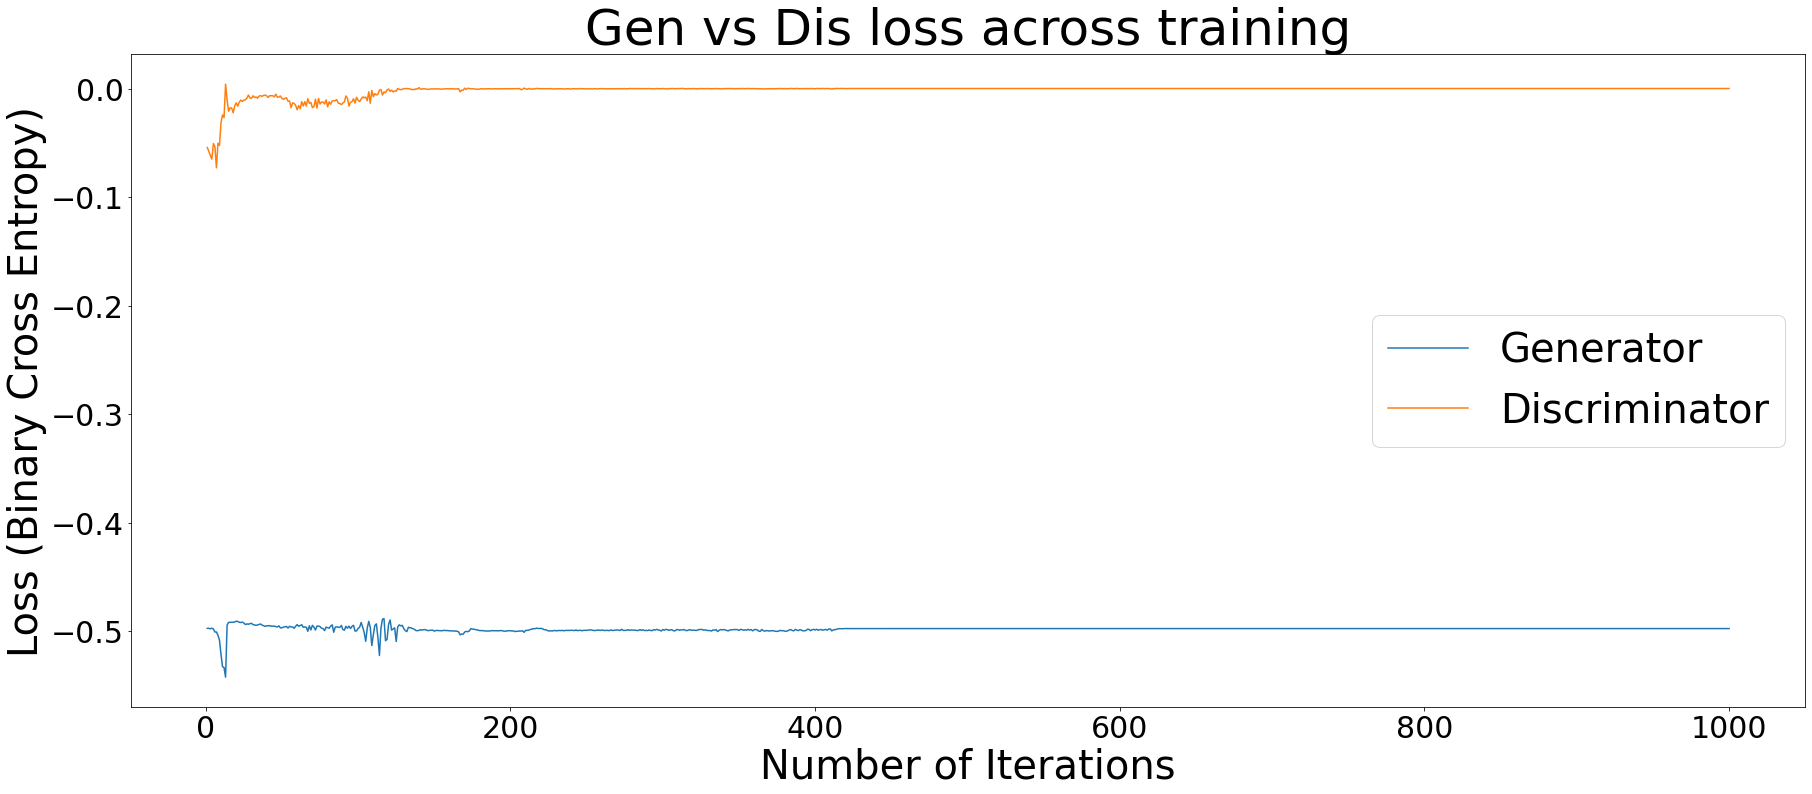

In [20]:
losses_g, losses_d = history[0], history[1]

fig, axes = plt.subplots(1,1, figsize=(30, 12))
ax1 = plt.subplot(1,1,1)

plt.plot(range(1,1001), losses_g, label = 'Generator')
plt.plot(range(1, 1001), losses_d, label = 'Discriminator')
ax1.tick_params(labelsize = 30)
ax1.set_xlabel('Number of Iterations', fontsize = 40)
ax1.set_ylabel('Loss (Binary Cross Entropy)', fontsize = 40)
plt.title('Gen vs Dis loss across training', fontsize = 50)
plt.legend(fontsize = 40)

# Testing Generated Samples from Trained Generator

In [21]:
df.label.value_counts()

0    549
1    342
Name: label, dtype: int64

In [22]:
def generate_samples(number_of_samples_to_generate, class_val):
    if class_val == 0:
        label = torch.zeros(number_of_samples_to_generate, dtype=torch.int).to(device)
    elif class_val == 1:
        label = torch.ones(number_of_samples_to_generate, dtype=torch.int).to(device)
        
        
    latent_space_samples = torch.randn(number_of_samples_to_generate, n_features).to(device)
    generated_samples = generator(latent_space_samples, label)
#     print('generated_samples: ', generated_samples.shape)
#     print('label: ', label.shape)
    generated_samples = torch.concat([generated_samples, label.reshape(number_of_samples_to_generate, 1)], \
                                     dim = 1)
    generated_samples = generated_samples.cpu().detach().numpy()
    df_generated = pd.DataFrame(generated_samples, columns = df.columns)
    
    return df_generated

In [23]:
df_generated_0 = generate_samples(549, 0)
df_generated_1 = generate_samples(342, 1)

# Checking distributions of synthetic data

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
df0 = df[df.label == 0]
df1 = df[df.label == 1]

<b> For class 0

FOR CLASS 0


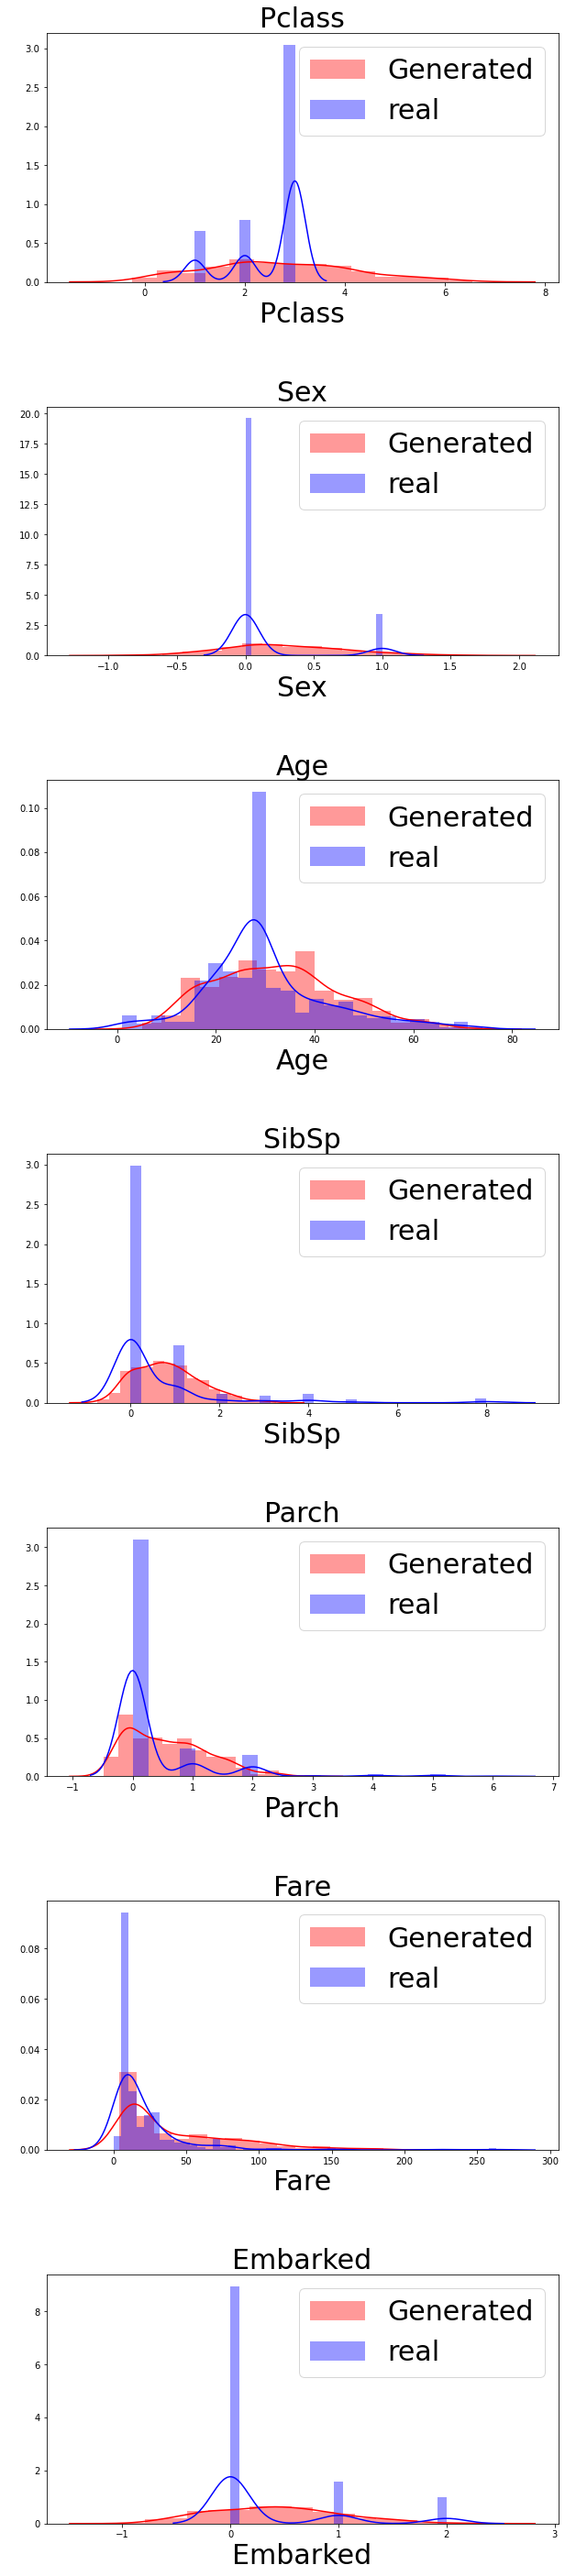

In [26]:
print('FOR CLASS 0')
fig, axes = plt.subplots(7, 1, figsize=(10, 50))

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(7,1, n+1)
    sns.distplot(x = df_generated_0[col], color = 'red', label = 'Generated')
    sns.distplot(x = df0[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 30)
    plt.xlabel(col, fontsize = 30)
    plt.title(col, fontsize = 30)
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)

<b> For class 1

FOR CLASS 1


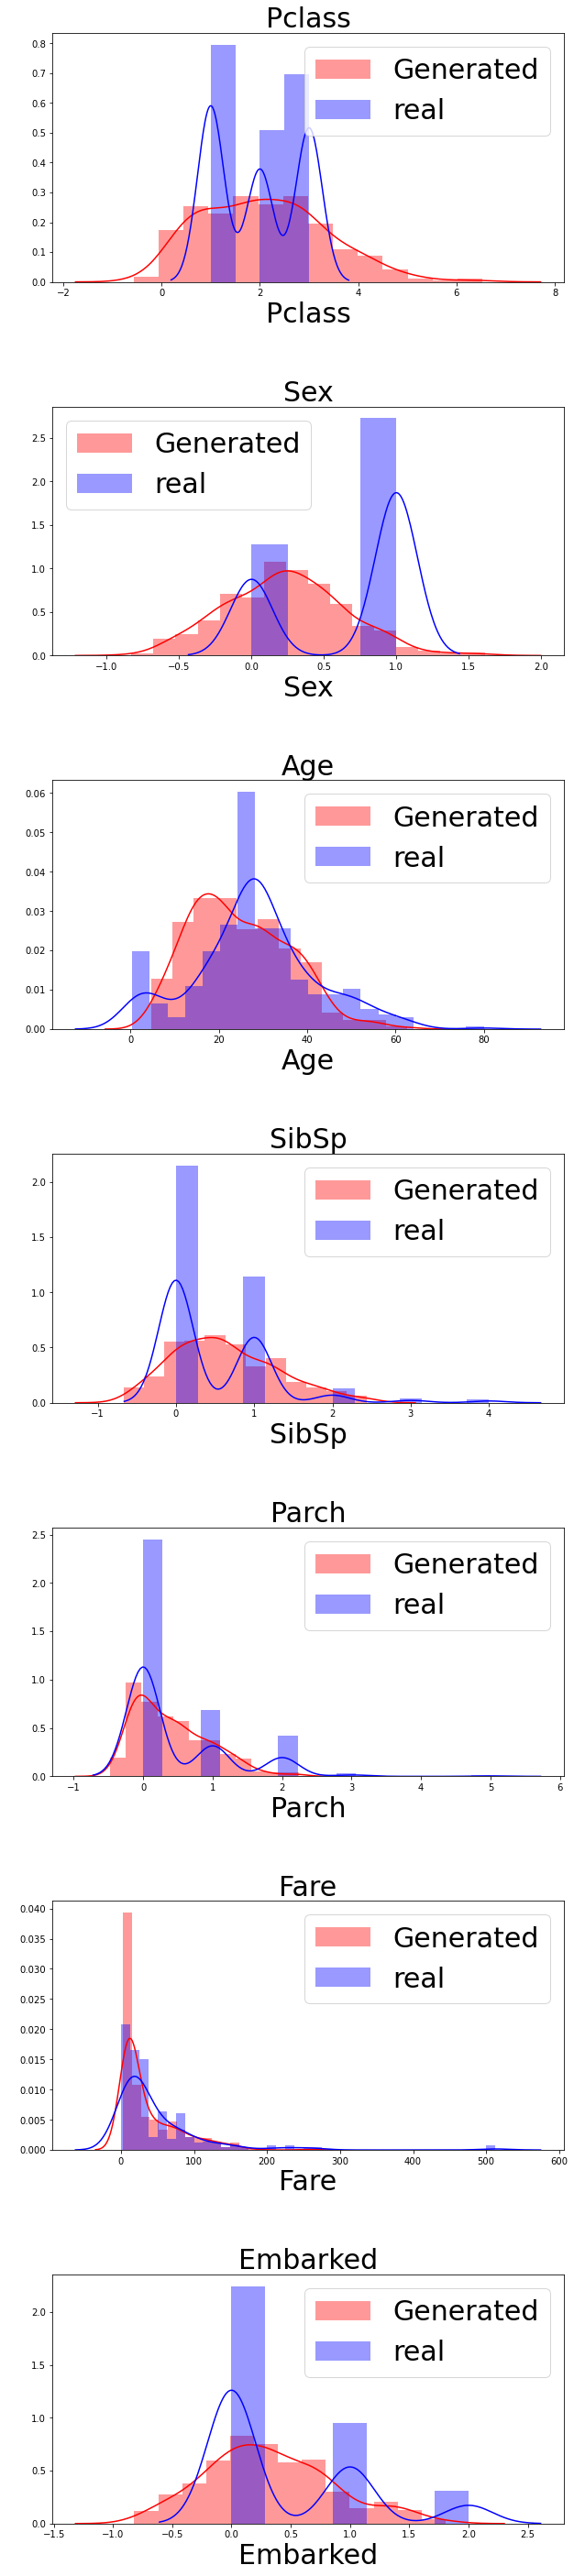

In [27]:
print('FOR CLASS 1')
fig, axes = plt.subplots(7, 1, figsize=(10, 50))

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(7,1, n+1)
    sns.distplot(x = df_generated_1[col], color = 'red', label = 'Generated')
    sns.distplot(x = df1[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 30)
    plt.xlabel(col, fontsize = 30)
    plt.title(col, fontsize = 30)
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)